In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\18162\AppData\Local\Temp\ipykernel_3560\4196587217.py:4: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
recent_date

'2017-08-23'

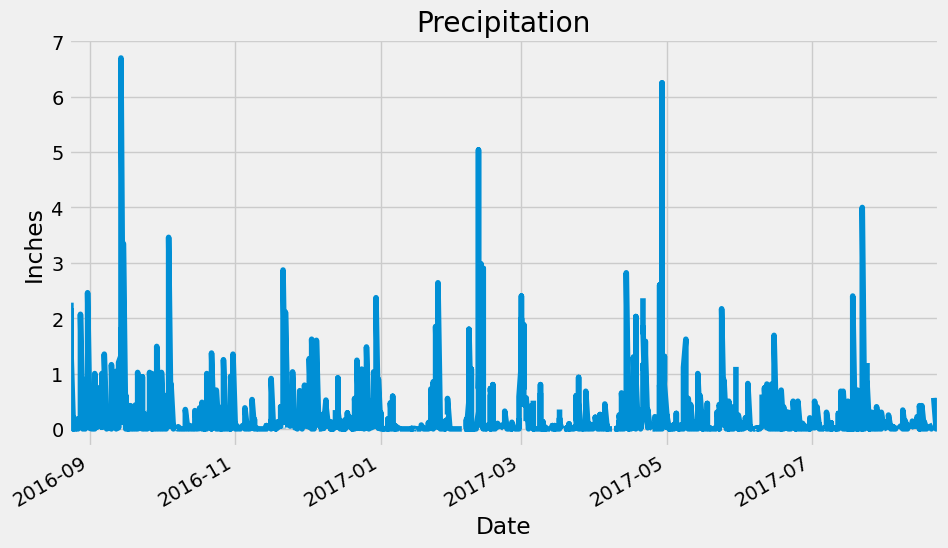

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
Last_year = dt.datetime.strptime(recent_date, r"%Y-%m-%d").date() - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date,
                               Measurement.prcp)\
                        .where(Measurement.date >= Last_year)\
                        .order_by(Measurement.date)\
                        .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(last_12_months, columns=["Date", "Precipitation"])
precipitation_df["Date"] = pd.to_datetime(precipitation_df["Date"], format=r"%Y-%m-%d")

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x="Date", y="Precipitation",
                      title="Precipitation", xlabel="Date", ylabel="Inches",
                      legend=False, figsize=(10, 6),
                      xlim=(Last_year, pd.Timestamp(recent_date)))
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).distinct().scalar()
total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station,
                                func.count(Measurement.station).label("count"))\
                         .join(Station, Measurement.station == Station.station)\
                         .group_by(Measurement.station)\
                         .order_by("count")\
                         .all()
active_stations

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0].station  # selecting from named tuple
most_active_data = session.query(func.min(Measurement.tobs).label("Min"),
                                 func.max(Measurement.tobs).label("Max"),
                                 func.avg(Measurement.tobs).label("Avg"))\
                           .where(Measurement.station == most_active_station)\
                           .one()
most_active_data

(58.0, 83.0, 72.72407045009784)

# Close Session

In [23]:
# Close Session
session.close()